## Weight  of evidence

Weight of Evidence (WoE) was developed primarily for the credit and financial industries to help build more predictive models to evaluate the risk of loan default. That is, to predict how likely the money lent to a person or institution is to be lost. Thus, Weight of Evidence is a measure of the "strength” of a grouping technique to separate good and bad risk (default). 

It is computed from the basic odds ratio: ln( (Proportion of Good Credit Outcomes) / (Proportion of Bad Credit Outcomes))

WoE will be 0 if the P(Goods) / P(Bads) = 1. That is, if the outcome is random for that group. If P(Bads) > P(Goods) the odds ratio will be < 1 and the WoE will be < 0; if, on the other hand, P(Goods) > P(Bads) in a group, then WoE > 0.

WoE is well suited for Logistic Regression, because the Logit transformation is simply the log of the odds, i.e., ln(P(Goods)/P(Bads)). Therefore, by using WoE-coded predictors in logistic regression, the predictors are all prepared and coded to the same scale, and the parameters in the linear logistic regression equation can be directly compared.

The WoE transformation has three advantages:

- It establishes a monotonic relationship to the dependent variable.
- It orders the categories on a "logistic" scale which is natural for logistic regression
- The transformed variables, can then be compared because they are on the same scale. Therefore, it is possible to determine which one is more predictive.

The WoE also has three drawbacks:

- May incur in loss of information (variation) due to binning to few categories (we will discuss this further in the discretisation section)
- It does not take into account correlation between independent variables
- Prone to cause over-fitting


For more details follow this link:

http://documentation.statsoft.com/StatisticaHelp.aspx?path=WeightofEvidence/WeightofEvidenceWoEIntroductoryOverview

Let's see how to implement WoE in python

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%cd ../data_set/
# let's load again the titanic dataset

data = pd.read_csv('titanic.csv', usecols=['Cabin', 'Survived'])
data.head()

/home/pat/Desktop/Udemy_FeatureEngineering/data_set


,Survived,Cabin
0,0,NaN
1,1,C85
2,1,NaN
3,1,C123
4,0,NaN


In [3]:
# let's first fill NA values with an additional label

data.Cabin.fillna('Missing', inplace=True)
data.head()

,Survived,Cabin
0,0,Missing
1,1,C85
2,1,Missing
3,1,C123
4,0,Missing


In [4]:
# Cabin has indeed a lot of labels, here for simplicity, I will capture the first letter of the cabin, 
# but the procedure could be done as well without any prior variable manipulation

len(data.Cabin.unique())

148

In [5]:
# Now we extract the first letter of the cabin

data['Cabin'] = data['Cabin'].astype(str).str[0]
data.head()

,Survived,Cabin
0,0,M
1,1,C
2,1,M
3,1,C
4,0,M


In [6]:
# check the labels
data.Cabin.unique()

array(['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

### Important

The calculation of the WoE to replace the labels should be done considering the ONLY the training set, and then expanded it to the test set.
See below.

In [7]:
# Let's divide into train and test set

X_train, X_test, y_train, y_test = train_test_split(data[['Cabin', 'Survived']], data.Survived, test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((623, 2), (268, 2))

In [8]:
# now we calculate the probability of target=1 
X_train.groupby(['Cabin'])['Survived'].mean()

Cabin
A    0.428571
B    0.774194
C    0.571429
D    0.692308
E    0.740741
F    0.666667
G    0.500000
M    0.303609
T    0.000000
Name: Survived, dtype: float64

In [9]:
# let's make a dataframe with the above calculation

prob_df = X_train.groupby(['Cabin'])['Survived'].mean()
prob_df = pd.DataFrame(prob_df)
prob_df

,Survived
Cabin,
A,0.428571
B,0.774194
C,0.571429
D,0.692308
E,0.740741
F,0.666667
G,0.500000
M,0.303609
T,0.000000


In [10]:
# and now the probability of target = 0 
# and we add it to the dataframe

prob_df = X_train.groupby(['Cabin'])['Survived'].mean()
prob_df = pd.DataFrame(prob_df)
prob_df['Died'] = 1-prob_df.Survived
prob_df

,Survived,Died
Cabin,,
A,0.428571,0.571429
B,0.774194,0.225806
C,0.571429,0.428571
D,0.692308,0.307692
E,0.740741,0.259259
F,0.666667,0.333333
G,0.500000,0.500000
M,0.303609,0.696391
T,0.000000,1.000000


In [11]:
# since the log of zero is not defined, let's set this number to something small and non-zero

prob_df.loc[prob_df.Survived == 0, 'Survived'] = 0.00001
prob_df

,Survived,Died
Cabin,,
A,0.428571,0.571429
B,0.774194,0.225806
C,0.571429,0.428571
D,0.692308,0.307692
E,0.740741,0.259259
F,0.666667,0.333333
G,0.500000,0.500000
M,0.303609,0.696391
T,0.000010,1.000000


In [12]:
# now we calculate the WoE

prob_df['WoE'] = np.log(prob_df.Survived/prob_df.Died)
prob_df

,Survived,Died,WoE
Cabin,,,
A,0.428571,0.571429,-0.287682
B,0.774194,0.225806,1.232144
C,0.571429,0.428571,0.287682
D,0.692308,0.307692,0.810930
E,0.740741,0.259259,1.049822
F,0.666667,0.333333,0.693147
G,0.500000,0.500000,0.000000
M,0.303609,0.696391,-0.830169
T,0.000010,1.000000,-11.512925


In [13]:
# and we create a dictionary to re-map the variable

prob_df['WoE'].to_dict()

{'A': -0.2876820724517809,
 'B': 1.232143681292632,
 'C': 0.28768207245178085,
 'D': 0.8109302162163288,
 'E': 1.0498221244986774,
 'F': 0.6931471805599452,
 'G': 0.0,
 'M': -0.8301689781242366,
 'T': -11.512925464970229}

In [14]:
# and we make a dictionary to map the orignal variable to the WoE
# same as above but we capture the dictionary in a variable

ordered_labels = prob_df['WoE'].to_dict()

In [15]:
# replace the labels with the WoE

X_train['Cabin_ordered'] = X_train.Cabin.map(ordered_labels)
X_test['Cabin_ordered'] = X_test.Cabin.map(ordered_labels)

In [16]:
# check the results

X_train.head()

,Cabin,Survived,Cabin_ordered
857,E,1,1.049822
52,D,1,0.810930
386,M,0,-0.830169
124,D,0,0.810930
578,M,0,-0.830169


Text(0, 0.5, 'Survived')

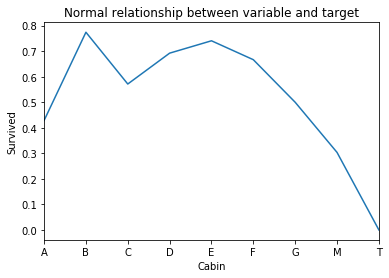

In [17]:
# plot the original variable

fig = plt.figure()
fig = X_train.groupby(['Cabin'])['Survived'].mean().plot()
fig.set_title('Normal relationship between variable and target')
fig.set_ylabel('Survived')

Text(0, 0.5, 'Survived')

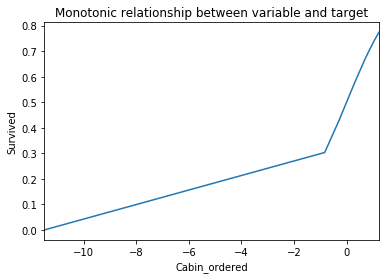

In [18]:
# plot the transformed result: the monotonic variable

fig = plt.figure()
fig = X_train.groupby(['Cabin_ordered'])['Survived'].mean().plot()
fig.set_title('Monotonic relationship between variable and target')
fig.set_ylabel('Survived')

As you can see in the above plot, there is now a monotonic relationship between the variable Cabin and probability of survival. The higher the Cabin number, the more likely the person was to survive.

### Note

Monotonic does not mean strictly linear. Monotonic means that it increases constantly, or it decreases constantly.